# Chapter 3 - Linear Regression

- [Lab 3.6.2 Simple Linear Regression](#lab-3.6.2)
- [Lab 3.6.3 Multiple Linear Regression](#lab-3.6.3)
- [Lab 3.6.4 Interaction Terms](#lab-3.6.4)
- [Lab 3.6.5 Non-linear Transformations of the Predictors](#lab-3.6.5)
- [Lab 3.6.6 Qualitative Predictors](#lab-3.6.6)
- [Exercise 8](#ex-8)
- [Exercise 9](#ex-9)

### Imports and Configurations

In [1]:
# Standard imports
import warnings

# Use rpy2 for loading R datasets
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import data as rdata
from rpy2.robjects import pandas2ri

# Math and data processing
import numpy as np
import scipy as sp
import pandas as pd

# StatsModels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.anova import anova_lm

# scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Visulization
from IPython.display import display, HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import statsmodels.graphics.api as smg

### Utility Functions Definitions

In [2]:
def ortho_poly_fit(x, degree = 1):
    '''
    Convert data into orthogonal basis for polynomial regression by QR decomposition.
    Ref: http://davmre.github.io/python/2013/12/15/orthogonal_poly
    '''
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            stop("'degree' must be less than number of unique points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, norm2, alpha

def ortho_poly_predict(x, alpha, norm2, degree = 1):
    '''
    Convert new data for prediction into orthogonal basis, based on input parameters.
    Ref: http://davmre.github.io/python/2013/12/15/orthogonal_poly
    '''
    x = np.asarray(x).flatten()
    n = degree + 1
    Z = np.empty((len(x), n))
    Z[:,0] = 1
    if degree > 0:
        Z[:, 1] = x - alpha[0]
    if degree > 1:
        for i in np.arange(1,degree):
            Z[:, i+1] = (x - alpha[i]) * Z[:, i] - (norm2[i] / norm2[i-1]) * Z[:, i-1]
    Z /= np.sqrt(norm2)
    return Z

<a id='lab-3.6.2'></a>

### Lab 3.6.2 Simple Linear Regression

In [3]:
# Import Boston house price data from R package MASS
# This dataset is also available at https://archive.ics.uci.edu/ml/datasets/Housing
mass = importr('MASS')
boston_rdf = rdata(mass).fetch('Boston')['Boston']
boston = pandas2ri.ri2py(boston_rdf)

In [4]:
# boston.describe  # Head and tails in text.
# display(boston)  # Head and tail in a data table.
HTML(boston.to_html(max_rows=60))  # All rows, or a subset in a data table.

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
6,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
10,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [5]:
boston.info()  # Summary of the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 1 to 506
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int32
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int32
tax        506 non-null float64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(12), int32(2)
memory usage: 55.3 KB


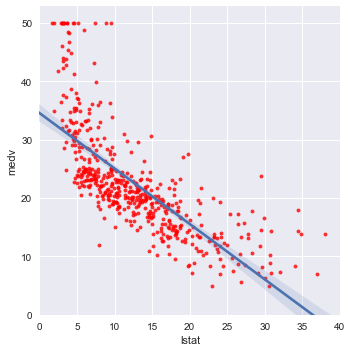

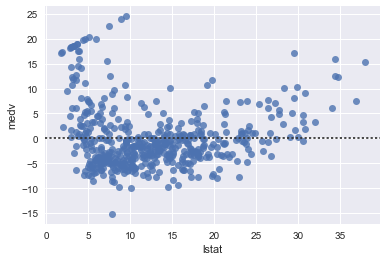

In [6]:
# Simple linear regression and plot using seaborn
sns.lmplot(x='lstat', y='medv', data=boston, scatter_kws={'color':'r', 's':15});
plt.xlim(xmin=0)
plt.ylim(ymin=0)
sns.plt.show()
plt.figure()
sns.residplot(x='lstat', y='medv', data=boston)
sns.plt.show()

In [7]:
# Simple linear regression with scikit-learn
boston_sk = LinearRegression()
nrow = boston.shape[0]
boston_sk.fit(boston['lstat'].values.reshape(nrow, 1), boston['medv'].values.reshape(nrow, 1))
print("Slope: {}, Intercept: {}".format(boston_sk.coef_, boston_sk.intercept_))

Slope: [[-0.95004935]], Intercept: [ 34.55384088]


In [8]:
# Simple linear regression with StatsModels
boston_smslr = smf.ols('medv ~ lstat', data=boston).fit()
print(boston_smslr.summary())
# Display residual SE and quantiles not shown in SM summary
print("\nResidual Standard Error:")
print(np.sqrt(boston_smslr.mse_resid))
print("\nResiduals:")
display(boston_smslr.resid.describe()[3:])

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Tue, 28 Feb 2017   Prob (F-statistic):           5.08e-88
Time:                        16:53:32   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

min   -15.167452
25%    -3.989612
50%    -1.318186
75%     2.033701
max    24.500129
dtype: float64

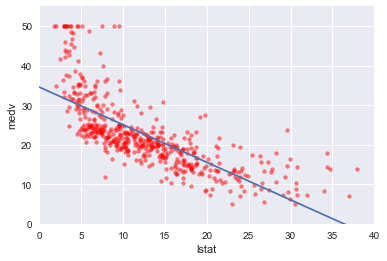

In [9]:
# Plot StatsModels OLS fitting results
fig, ax = plt.subplots()
plt.scatter(boston.lstat, boston.medv, color='r', s=15, alpha=0.5)  # Data points
smg.abline_plot(model_results=boston_smslr, ax=ax)  # Regression line
plt.xlim(0, 40)
plt.ylim(0, 55)
plt.xlabel('lstat')
plt.ylabel('medv')
plt.show()

In [10]:
# 97.5% confidence interval for the coefficient estimates
ci = boston_smslr.conf_int(0.025)
ci.columns = ['2.5%', '97.5%']
print(ci)

                2.5%      97.5%
Intercept  33.288987  35.818694
lstat      -1.037127  -0.862972


We can see the confidence interval computed by StatsModels is slightly difference than R.

In [11]:
# Prediction (To be finished)
fit = boston_smslr.predict(exog=dict(lstat=[5,10,15]))
print(fit)
# Prediction Intervals
#from statsmodels.sandbox.regression.predstd import wls_prediction_std
#prstd, iv_l, iv_u = wls_prediction_std(boston_smslr)
#print(prstd,iv_l,iv_u)

# Confidence Intervals

[ 29.80359411  25.05334734  20.30310057]


References:
http://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels
http://stackoverflow.com/questions/20572706/mathematical-background-of-statsmodels-wls-prediction-std
http://markthegraph.blogspot.com/2015/05/using-python-statsmodels-for-ols-linear.html
http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/wls.html?highlight=wls_prediction_std

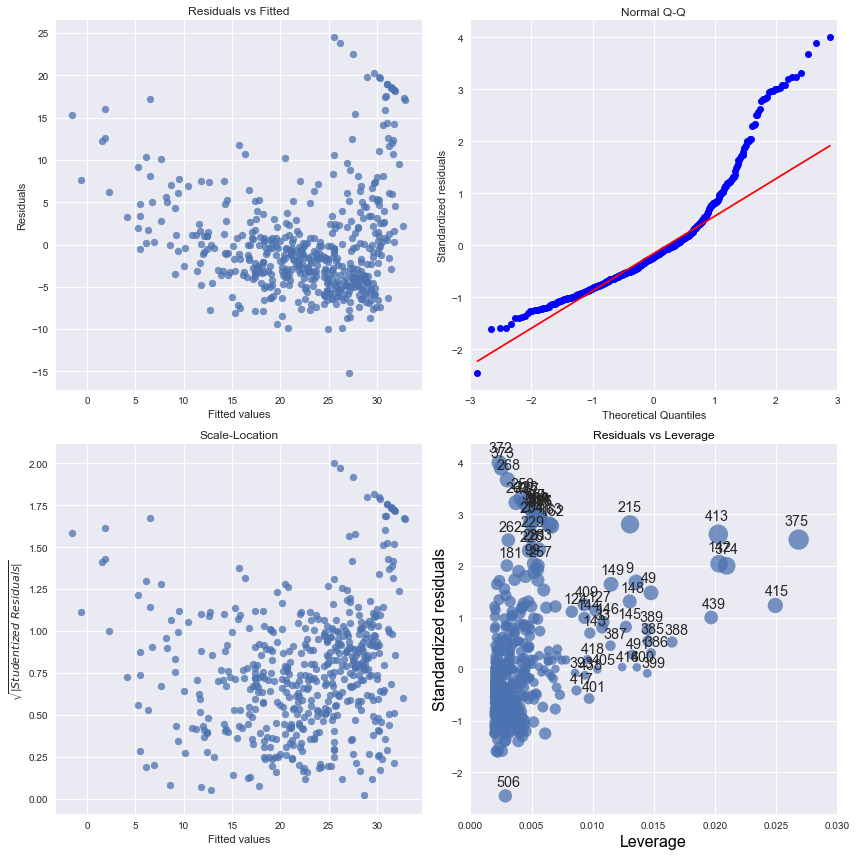

In [12]:
# Diagnostic plots for simple linear regression
infl = boston_smslr.get_influence()
fig, ax = plt.subplots(2, 2, figsize=(12,12))

# 1. Residuals. vs. fitted values
ax1 = plt.subplot(221)
plt.scatter(boston_smslr.fittedvalues, boston_smslr.resid, alpha=0.75)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

# 2. Normal Q-Q plot
ax2 = plt.subplot(222)
smg.qqplot(infl.resid_studentized_external, line='q', ax=ax2)
plt.title('Normal Q-Q')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized residuals')

# 3. Square-root absolute standardized residuals vs. fitted values
ax3 = plt.subplot(223)
plt.scatter(boston_smslr.fittedvalues, np.sqrt(np.absolute(infl.resid_studentized_external)), alpha=0.75)
plt.title('Scale-Location')
plt.xlabel('Fitted values')
plt.ylabel(r'$\sqrt{|Studentized\ Residuals|}$')

# 4. Standardized residuals vs. leverage statistics
ax4 = plt.subplot(224)
smg.influence_plot(boston_smslr, size=20, ax=ax4)
plt.xlim(0, 0.03)
plt.xlabel('Leverage')
plt.ylabel('Standardized residuals')
plt.title('Residuals vs Leverage')

plt.tight_layout()
plt.show()

In [13]:
# Find the data index with the maximum leverage statistics
infl.hat_matrix_diag.argmax() + 1

375

<a id='lab-3.6.3'></a>

### Lab 3.6.3 Multiple Linear Regression

In [14]:
# Regression with two predictors on Boston dataset
boston_smmlr = smf.ols('medv ~ lstat + age', data=boston).fit()
print(boston_smmlr.summary())
# Display residual SE and quantiles not shown in SM summary
print("\nResidual Standard Error:")
print(np.sqrt(boston_smmlr.mse_resid))
print("\nResiduals:")
print(boston_smmlr.resid.describe()[3:])

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Tue, 28 Feb 2017   Prob (F-statistic):           2.98e-88
Time:                        16:53:33   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     33.2228      0.731     45.458      0.0

In [15]:
# Regression with all predictors on Boston dataset
all_predictors = '+'.join(boston.columns.drop('medv'))
boston_smmlr_all = smf.ols('medv ~ ' + all_predictors, data=boston).fit()
print(boston_smmlr_all.summary())
# Display residual SE and quantiles not shown in SM summary
print("\nResidual Standard Error:")
print(np.sqrt(boston_smmlr_all.mse_resid))
print("\nResiduals:")
print(boston_smmlr_all.resid.describe()[3:])

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 28 Feb 2017   Prob (F-statistic):          6.72e-135
Time:                        16:53:34   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

In [16]:
# Compute variance inflation factors
exog = boston_smmlr_all.model.exog
exog_names = boston_smmlr_all.model.exog_names
vif_df = pd.DataFrame([vif(exog, ix) for ix in range(1, exog.shape[1])]).transpose()
vif_df.columns = exog_names[1:]
display(vif_df)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,1.792192,2.298758,3.991596,1.073995,4.39372,1.933744,3.100826,3.955945,7.484496,9.008554,1.799084,1.348521,2.941491


<a id='lab-3.6.4'></a>

### Lab 3.6.4 Interaction Terms

In [17]:
# Regression with two interaction terms on Boston dataset
boston_smmlr_inter = smf.ols('medv ~ lstat * age', data=boston).fit()
print(boston_smmlr_inter.summary())
# Display residual SE and quantiles not shown in SM summary
print("\nResidual Standard Error:")
print(np.sqrt(boston_smmlr_inter.mse_resid))
print("\nResiduals:")
print(boston_smmlr_inter.resid.describe()[3:])

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Tue, 28 Feb 2017   Prob (F-statistic):           4.86e-88
Time:                        16:53:34   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.0

<a id='lab-3.6.5'></a>

### Lab 3.6.5 Non-linear Transformations of the Predictors

In [18]:
# Regression with quandratic term on Boston dataset
boston_smmlr_quad = smf.ols('medv ~ lstat + I(lstat**2)', data=boston).fit()
print(boston_smmlr_quad.summary())
# Display residual SE and quantiles not shown in SM summary
print("\nResidual Standard Error:")
print(np.sqrt(boston_smmlr_quad.mse_resid))
print("\nResiduals:")
print(boston_smmlr_quad.resid.describe()[3:])

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Tue, 28 Feb 2017   Prob (F-statistic):          1.56e-112
Time:                        16:53:34   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149

In [19]:
# ANOVA for both simple linear and quandratic fits
with warnings.catch_warnings(): 
    warnings.filterwarnings("ignore")  ## Supress warnings
    display(anova_lm(boston_smslr, boston_smmlr_quad))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,19472.381418,0.0,NaN,NaN,NaN
1,503.0,15347.243158,1.0,4125.13826,135.199822,7.630116e-28


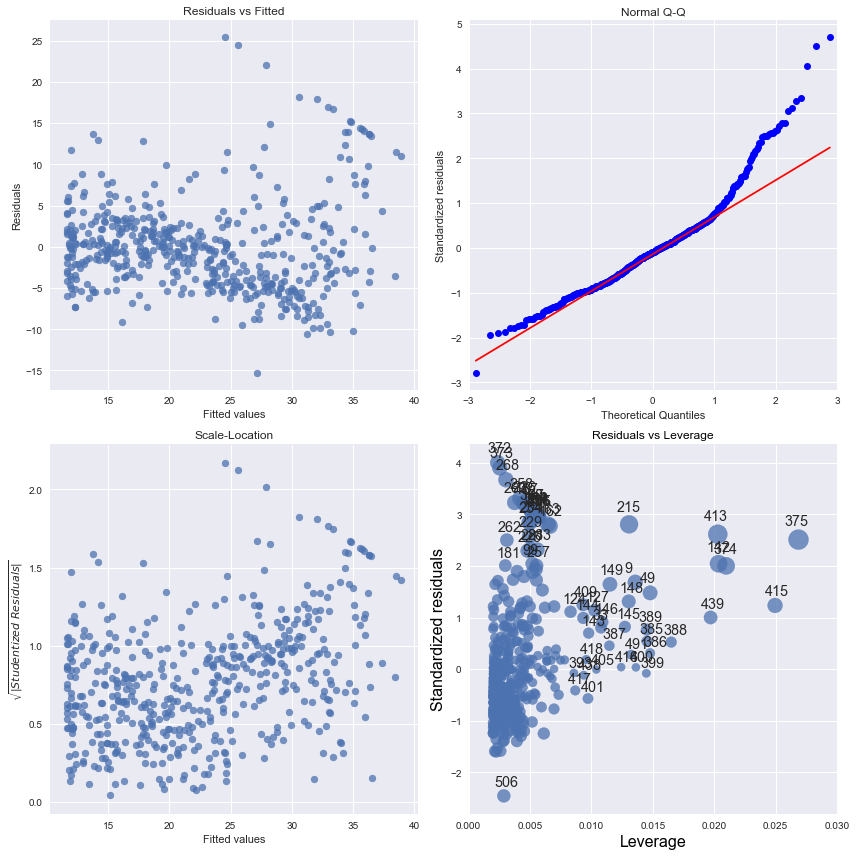

In [20]:
# Diagnostic plots for quandratic fit
infl = boston_smmlr_quad.get_influence()
fig, ax = plt.subplots(2, 2, figsize=(12,12))

# 1. Residuals. vs. fitted values
ax1 = plt.subplot(221)
plt.scatter(boston_smmlr_quad.fittedvalues, boston_smmlr_quad.resid, alpha=0.75)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

# 2. Normal Q-Q plot
ax2 = plt.subplot(222)
smg.qqplot(infl.resid_studentized_external, line='q', ax=ax2)
plt.title('Normal Q-Q')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized residuals')

# 3. Square-root absolute standardized residuals vs. fitted values
ax3 = plt.subplot(223)
plt.scatter(boston_smmlr_quad.fittedvalues, np.sqrt(np.absolute(infl.resid_studentized_external)), alpha=0.75)
plt.title('Scale-Location')
plt.xlabel('Fitted values')
plt.ylabel(r'$\sqrt{|Studentized\ Residuals|}$')

# 4. Standardized residuals vs. leverage statistics
ax4 = plt.subplot(224)
smg.influence_plot(boston_smslr, size=20, ax=ax4)
plt.xlim(0, 0.03)
plt.xlabel('Leverage')
plt.ylabel('Standardized residuals')
plt.title('Residuals vs Leverage')

plt.tight_layout()
plt.show()

In [21]:
# Regression with polynomial terms on Boston dataset
# poly() function in R produces orthogonal polynomials with QR decomposition by default
# Without orthogonization, powers of X are correlated, and regression on correlated predictors
# leads tounstable coefficients.
# In addition, large powers of X will require very small regression coefficients,
# potentially leading to underflow and coefficients that are hard to interpret or compare intuitively.
# Ref: http://davmre.github.io/python/2013/12/15/orthogonal_poly
poly_degree = 5
boston_smmlr_poly = smf.ols('medv ~ ortho_poly_fit(lstat, poly_degree)[0][:, 1:]', data=boston).fit()
print(boston_smmlr_poly.summary())
# Display residual SE and quantiles not shown in SM summary
print("\nResidual Standard Error:")
print(np.sqrt(boston_smmlr_poly.mse_resid))
print("\nResiduals:")
print(boston_smmlr_poly.resid.describe()[3:])

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Tue, 28 Feb 2017   Prob (F-statistic):          8.73e-122
Time:                        16:53:35   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------

<a id='lab-3.6.6'></a>

### Lab 3.6.6 Qualitative Predictors

In [22]:
# Import Carseats data from R package ISLR
islr = importr('ISLR')
carseats_rdf = rdata(islr).fetch('Carseats')['Carseats']
carseats = pandas2ri.ri2py(carseats_rdf)
display(carseats)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
1,9.50,138.0,73.0,11.0,276.0,120.0,Bad,42.0,17.0,Yes,Yes
2,11.22,111.0,48.0,16.0,260.0,83.0,Good,65.0,10.0,Yes,Yes
3,10.06,113.0,35.0,10.0,269.0,80.0,Medium,59.0,12.0,Yes,Yes
4,7.40,117.0,100.0,4.0,466.0,97.0,Medium,55.0,14.0,Yes,Yes
5,4.15,141.0,64.0,3.0,340.0,128.0,Bad,38.0,13.0,Yes,No
6,10.81,124.0,113.0,13.0,501.0,72.0,Bad,78.0,16.0,No,Yes
7,6.63,115.0,105.0,0.0,45.0,108.0,Medium,71.0,15.0,Yes,No
8,11.85,136.0,81.0,15.0,425.0,120.0,Good,67.0,10.0,Yes,Yes
9,6.54,132.0,110.0,0.0,108.0,124.0,Medium,76.0,10.0,No,No
10,4.69,132.0,113.0,0.0,131.0,124.0,Medium,76.0,17.0,No,Yes


In [23]:
# Regression with all terms plus two interaction terms on Carseats dataset
all_predictors = '+'.join(carseats.columns.drop('Sales'))
carseats_smmlr = smf.ols('Sales ~ ' + all_predictors + ' + Income:Advertising + Price:Age', data=carseats).fit()
print(carseats_smmlr.summary())
# Display residual SE and quantiles not shown in SM summary
print("\nResidual Standard Error:")
print(np.sqrt(carseats_smmlr.mse_resid))
print("\nResiduals:")
print(carseats_smmlr.resid.describe()[3:])

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Tue, 28 Feb 2017   Prob (F-statistic):          6.14e-166
Time:                        16:53:35   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               6.5756    

In [24]:
# Show contrast matrix, the dummy variable coding
from patsy.contrasts import Treatment
levels = list(carseats.ShelveLoc.unique())
contrast = Treatment(reference=0).code_without_intercept(levels)
cm_df = pd.DataFrame(contrast.matrix, columns=contrast.column_suffixes, index=levels, dtype=int)
display(cm_df)

,[T.Good],[T.Medium]
Bad,0,0
Good,1,0
Medium,0,1


<a id='ex-8'></a>

### Exercise 8

In [25]:
# Auto dataset is in R ISLR package
islr = importr('ISLR')
auto_rdf = rdata(islr).fetch('Auto')['Auto']
auto = pandas2ri.ri2py(auto_rdf)
display(auto)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
2,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
3,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
4,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
5,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino
6,15.0,8.0,429.0,198.0,4341.0,10.0,70.0,1.0,ford galaxie 500
7,14.0,8.0,454.0,220.0,4354.0,9.0,70.0,1.0,chevrolet impala
8,14.0,8.0,440.0,215.0,4312.0,8.5,70.0,1.0,plymouth fury iii
9,14.0,8.0,455.0,225.0,4425.0,10.0,70.0,1.0,pontiac catalina
10,15.0,8.0,390.0,190.0,3850.0,8.5,70.0,1.0,amc ambassador dpl


In [26]:
# simple linear regression on Auto dataset
auto_slr = smf.ols('mpg ~ horsepower ', data=auto).fit()
print(auto_slr.summary())
# Display residual SE and quantiles not shown in SM summary
print("\nResidual Standard Error:")
print(np.sqrt(auto_slr.mse_resid))
print("\nResiduals:")
print(auto_slr.resid.describe()[3:])

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 28 Feb 2017   Prob (F-statistic):           7.03e-81
Time:                        16:53:35   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.0

In [27]:
# 8 (a) - iv. Prediction
auto_pred = auto_slr.predict(exog=dict(horsepower=98))
print(auto_pred)

[ 24.46707715]


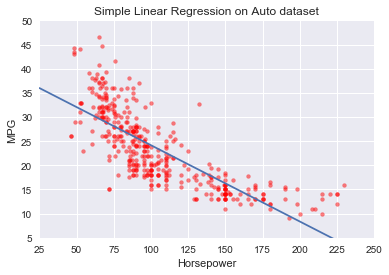

In [28]:
# Plot SLR fitting results
fig, ax = plt.subplots()
plt.scatter(auto.horsepower, auto.mpg, color='r', s=15, alpha=0.5)  # Data points
smg.abline_plot(model_results=auto_slr, ax=ax)  # Regression line
plt.xlim(25, 250)
plt.ylim(5, 50)
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Simple Linear Regression on Auto dataset')
plt.show()

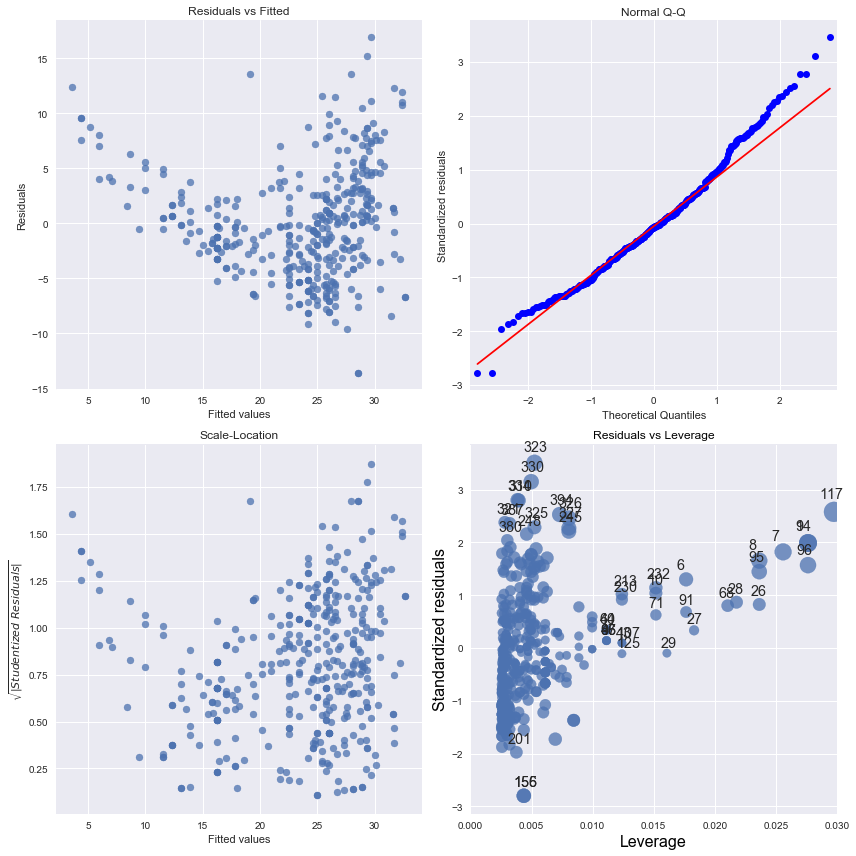

In [29]:
# Diagnostic plots
infl = auto_slr.get_influence()
fig, ax = plt.subplots(2, 2, figsize=(12,12))

# 1. Residuals. vs. fitted values
ax1 = plt.subplot(221)
plt.scatter(auto_slr.fittedvalues, auto_slr.resid, alpha=0.75)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

# 2. Normal Q-Q plot
ax2 = plt.subplot(222)
smg.qqplot(infl.resid_studentized_internal, line='q', ax=ax2)
plt.title('Normal Q-Q')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized residuals')

# 3. Square-root absolute standardized residuals vs. fitted values
ax3 = plt.subplot(223)
plt.scatter(auto_slr.fittedvalues, np.sqrt(np.absolute(infl.resid_studentized_external)), alpha=0.75)
plt.title('Scale-Location')
plt.xlabel('Fitted values')
plt.ylabel(r'$\sqrt{|Studentized\ Residuals|}$')

# 4. Standardized residuals vs. leverage statistics
ax4 = plt.subplot(224)
smg.influence_plot(auto_slr, size=20, ax=ax4)
plt.xlim(0, 0.03)
plt.xlabel('Leverage')
plt.ylabel('Standardized residuals')
plt.title('Residuals vs Leverage')

plt.tight_layout()
plt.show()

<a id='ex-9'></a>

### Exercise 9

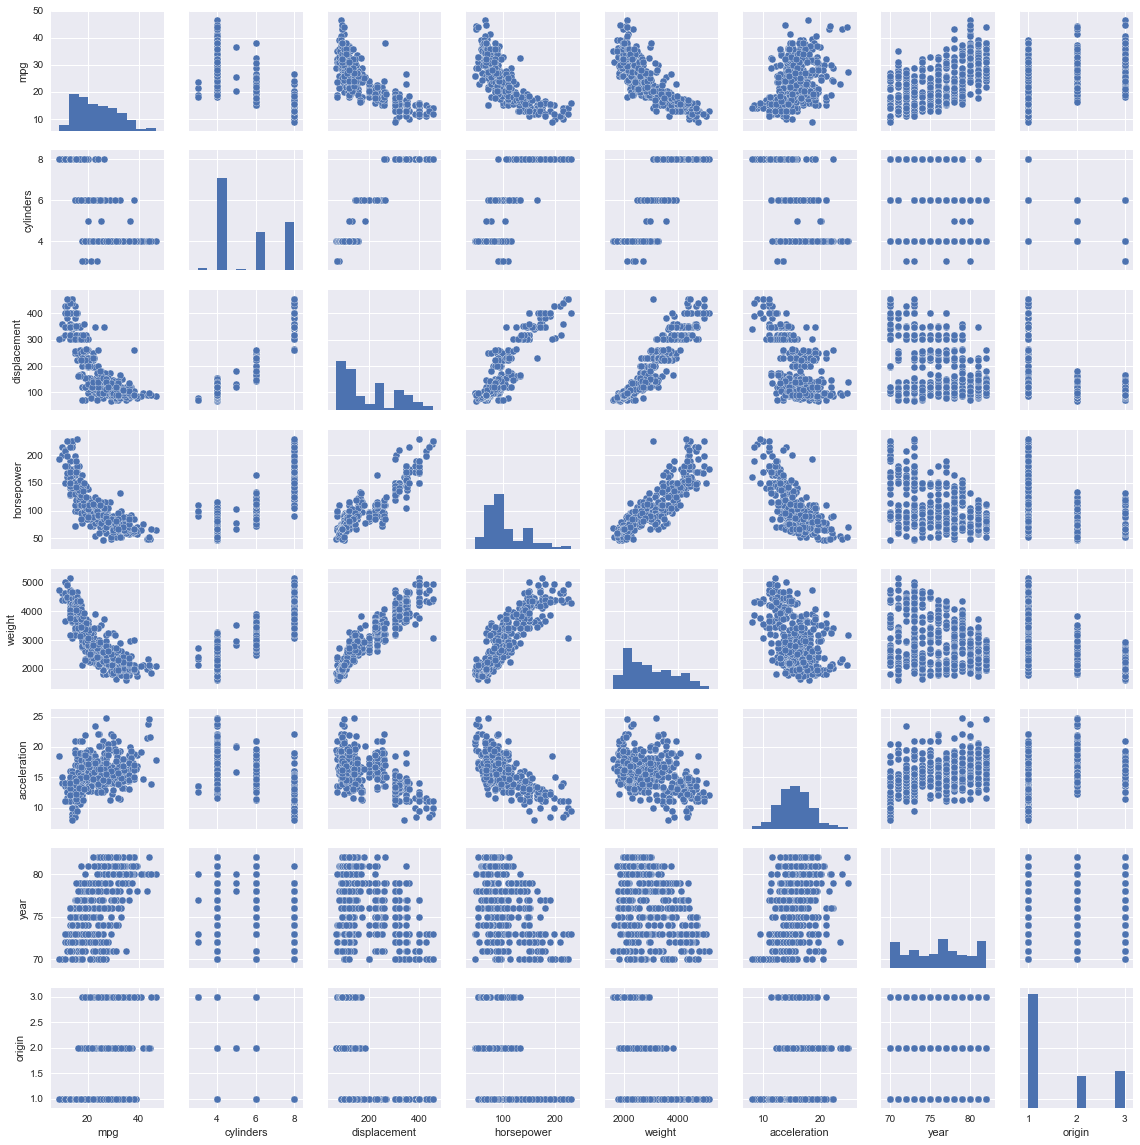

In [30]:
# 9 - (a) Plot scatter matrix.
sns.pairplot(auto, size=2)
plt.show()

In [31]:
# 9 - (b) Compute correlation matrix.
auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


In [32]:
# 9 - (c) Multiple linear regression on Auto dataset.
formula = 'mpg ~ ' + ' + '.join(auto.columns.drop(['name', 'mpg']))
print('\nRegression formula: {}\n'.format(formula))
auto_mlr = smf.ols(formula, data=auto).fit()
print(auto_mlr.summary())
# Display residual SE and quantiles not shown in SM summary
print("\nResidual Standard Error:")
print(np.sqrt(auto_mlr.mse_resid))
print("\nResiduals:")
print(auto_mlr.resid.describe()[3:])


Regression formula: mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + origin

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Tue, 28 Feb 2017   Prob (F-statistic):          2.04e-139
Time:                        16:53:43   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------

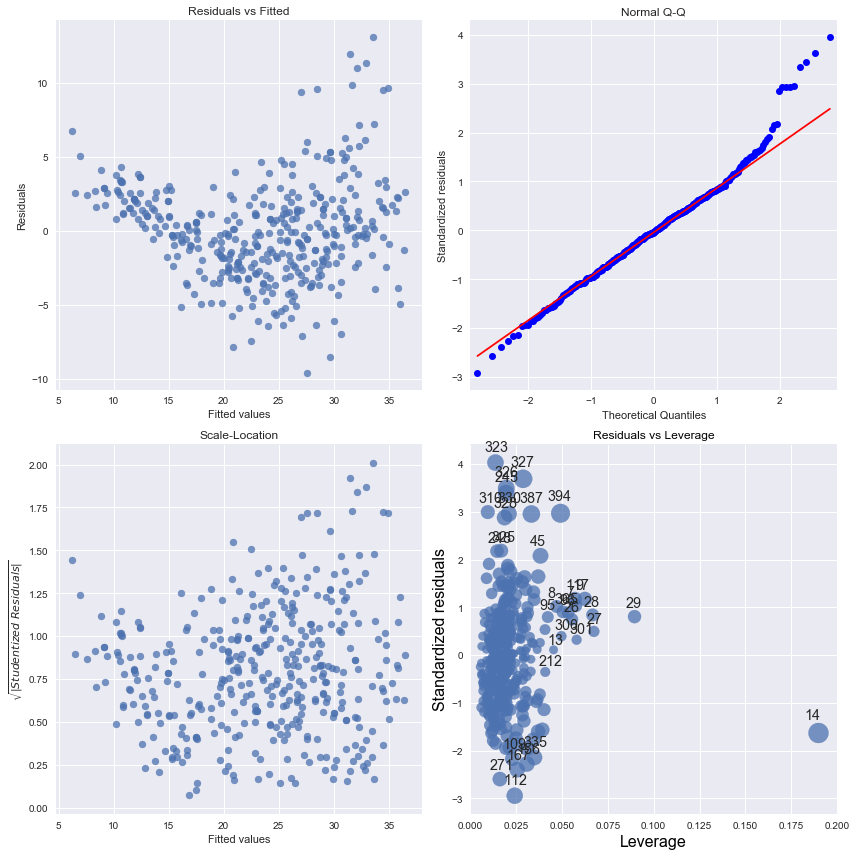

In [33]:
# Diagnostic plots
infl = auto_mlr.get_influence()
fig, ax = plt.subplots(2, 2, figsize=(12,12))

# 1. Residuals. vs. fitted values
ax1 = plt.subplot(221)
plt.scatter(auto_mlr.fittedvalues, auto_mlr.resid, alpha=0.75)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

# 2. Normal Q-Q plot
ax2 = plt.subplot(222)
smg.qqplot(infl.resid_studentized_internal, line='q', ax=ax2)
plt.title('Normal Q-Q')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized residuals')

# 3. Square-root absolute standardized residuals vs. fitted values
ax3 = plt.subplot(223)
plt.scatter(auto_mlr.fittedvalues, np.sqrt(np.absolute(infl.resid_studentized_external)), alpha=0.75)
plt.title('Scale-Location')
plt.xlabel('Fitted values')
plt.ylabel(r'$\sqrt{|Studentized\ Residuals|}$')

# 4. Standardized residuals vs. leverage statistics
ax4 = plt.subplot(224)
smg.influence_plot(auto_mlr, size=20, ax=ax4)
plt.xlim(0, 0.2)
plt.xlabel('Leverage')
plt.ylabel('Standardized residuals')
plt.title('Residuals vs Leverage')

plt.tight_layout()
plt.show()

In [34]:
# 9 - (e) Multiple linear regression with interaction terms on Auto dataset.
formula = 'mpg ~ ' + ' + '.join(auto.columns.drop(['name', 'mpg'])) + ' + horsepower:weight'
print('\nRegression formula: {}\n'.format(formula))
auto_mlr_inter = smf.ols(formula, data=auto).fit()
print(auto_mlr_inter.summary())
# Display residual SE and quantiles not shown in SM summary
print("\nResidual Standard Error:")
print(np.sqrt(auto_mlr_inter.mse_resid))
print("\nResiduals:")
print(auto_mlr_inter.resid.describe()[3:])


Regression formula: mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + origin + horsepower:weight

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     298.6
Date:                Tue, 28 Feb 2017   Prob (F-statistic):          1.88e-159
Time:                        16:53:45   Log-Likelihood:                -973.24
No. Observations:                 392   AIC:                             1964.
Df Residuals:                     383   BIC:                             2000.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.